> this notebook has 2 major steps:
1. the model is built and trained on data then it is tested on unseen data
    a. run the training of the classifier few times and consider as metrics avg loss and accuracy
2. the model is tuned and a new one is build with the best parameters, the later is trained and tested again
3. the 3rd model is the iteration of 2nd that takes nr of epochs to train to be the nr of best epoch +1 of tuned model
at the end the results are comapared

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feb13-10/feb13-10.csv
/kaggle/input/labeled-data/labeled_data.xlsx
/kaggle/input/laser3h5/laser3.h5
/kaggle/input/data-labeled/data_labeled.csv
/kaggle/input/test-nr-1/test1.xlsx
/kaggle/input/test6-unlabeled/feb28.xlsx
/kaggle/input/test5-labeled/test5_all.xlsx
/kaggle/input/test-nr-2/feb13-5.csv
/kaggle/input/test-nr-3/test2.xlsx
/kaggle/input/random-data-stream-final/Random_data_stream_final.csv
/kaggle/input/nistdata/nist-data.csv
/kaggle/input/stream-data/stream_data.xlsx
/kaggle/input/stream-data-predictions/stream_data_predictions.xlsx


> Import Datasets here

In [2]:
NIST = pd.read_csv('../input/nistdata/nist-data.csv')
print('the vulnerabily description from 2022 report: ')
print(NIST.shape)

NIST = NIST.drop_duplicates(subset=['full_text'])
drop_indices = np.random.choice(NIST.index, 10000, replace=True)
NIST = NIST.drop(drop_indices)
NIST.reset_index(inplace=True, drop=True)
NIST['label'] = 1
print('the vulnerabily description from 2022 report: ')
print(NIST.shape)
#drop_indices = np.random.choice(NIST.index, 9000, replace=True)
#NIST = NIST.drop(drop_indices)
data_labeled = pd.read_excel('/kaggle/input/labeled-data/labeled_data.xlsx')
print('labeled tweets from keyword filtered stream: ')
print(data_labeled.shape)
test5 = pd.read_excel('/kaggle/input/test5-labeled/test5_all.xlsx')
print('labeled test set also from keyword filtered stream: ')
print(test5.shape)

the vulnerabily description from 2022 report: 
(16359, 5)
the vulnerabily description from 2022 report: 
(8081, 6)
labeled tweets from keyword filtered stream: 
(13919, 43)
labeled test set also from keyword filtered stream: 
(223, 18)


In [3]:
test5

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,tweetid,author_id,full_text,label,lang,created_at,geo,retweets,replies,likes,quotes,location,full_text_clean,predictions,Unnamed: 5
0,0,0,2729,1.628442e+18,39302152,CVEnew: CVE-2021-4326 A vulnerability in Imper...,1,en,2023-02-22T17:11:57.000Z,{},0,0,0,0,CL,cvenew cve vulnerability imperative framework ...,0.997695,NaN
1,1,1,4960,1.628444e+18,958005194398289920,New post from https://t.co/9KYxtdZjkl (CVE-201...,1,en,2023-02-22T17:16:26.000Z,{},0,0,0,0,NaN,cve librarian function php url server request ...,0.997263,NaN
2,2,2,4954,1.628444e+18,955014888446939136,New post from https://t.co/uXvPWJy6tj (CVE-201...,1,en,2023-02-22T17:16:25.000Z,{},0,0,0,0,/dev/null,cve librarian function php url server request ...,0.997263,NaN
3,3,3,3281,1.628443e+18,429580982,#Cisco NX-OS Software CLI Command Injection #v...,1,en,2023-02-22T17:13:05.000Z,{},0,0,0,0,255.255.255.255,cisco nx software cli command injection vulner...,0.995187,NaN
4,4,4,1637,1.628442e+18,1322315722287099904,CVE-2023-21839 #Vulnerability for @Oracle #Web...,1,en,2023-02-22T17:09:26.000Z,{},0,0,0,0,United States,cve vulnerability oracle weblogic affect funct...,0.994816,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,11788,109,595,1.627998e+18,1126497628479315968,"#malware #Formbook #xloader ""NEW ORDER""\n\n⚙️r...",1,en,2023-02-21T11:45:06.000Z,{},0,0,0,0,NaN,malware formbook xloader real kenymart online ...,0.782271,NaN
219,11790,111,4525,1.628001e+18,1498420410597223936,@Eliteaviator2 @Zammy_bg @Tendar I can see no ...,0,en,2023-02-21T11:57:38.000Z,{},0,0,0,0,Czech Republic,eliteaviator zammy tendar danger russia stateh...,0.780000,NaN
220,11791,112,2551,1.627999e+18,85741735,"@taparware For security reasons, we don't have...",0,en,2023-02-21T11:51:08.000Z,{},0,0,0,0,NaN,taparware security reason access account twitt...,0.776551,NaN
221,11792,113,146,1.627997e+18,1106808919219798016,RT @bambifam76: Kai vlog and bbl update\nKyung...,1,en,2023-02-21T11:43:35.000Z,{},18,0,0,0,NaN,rt bambifam vlog bbl update kyungsoo update nm...,0.775203,NaN


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install sweetviz
!pip install contractions
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import contractions
import sweetviz as sv
import nltk
nltk.download('omw-1.4')
#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
import re  
import collections
# Counting the number of words
from collections import Counter
import time

#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
import re  
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from sklearn import preprocessing

import nltk # NLP  
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import re  

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

#Tuner
from keras_tuner.tuners import RandomSearch


import tabulate
from tabulate import tabulate
import sweetviz as sv

#confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# cross validation and metrics
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer
from unidecode import unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 12.2 MB/s eta 0:00:00


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


> text cleanning

In [5]:
# !pip install stopwordsiso
# import stopwordsiso
# from stopwordsiso import stopwords
# stopwords = stopwords(['af', 'ar', 'hy', 'eu', 'bn', 'br', 'bg', 'ca', 'zh', 'hr', 'cs', 'da', 'nl', 'en', 'eo', 'et', 'fi', 'fr', 'gl', 'de', 'el', 'gu', 'ha', 'he', 'hi', 'hu', 'id', 'ga', 'it', 'ja', 'ko', 'ku', 'la', 'lt', 'lv', 'ms', 'mr', 'no', 'fa', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'so', 'st', 'es', 'sw', 'sv', 'th', 'tl', 'tr', 'uk', 'ur', 'vi', 'yo', 'zu'])  # German, Indonesian, and Chinese stopwords
# # Removing stop words
# def remove_stop_words(text):
#     return ' '.join([word for word in text.split() if word not in stopwords])

# def remove_hashtag(text):
#     return re.sub(r'#\w+', '', text)

# def remove_dog(text):
#     return re.sub(r'@\w+', '', text)

# def remove_punctuations(text):
#     return re.sub('\[[^]]*\]!?.,:;', '', text)

# def remove_characters(text):
#     return re.sub('!$%^&*()_+=-></', ' ', text)

# def remove_url(text):
#     return re.sub(r'http\S+', '', text)

# def remove_urls(text):
#     return re.sub(r'https:\S+', '', text)

# def remove_contractions(text):
#     return ' '.join([contractions.fix(word) for word in text.split()])

# #defining the object for Lemmatization
# lemmatizer = WordNetLemmatizer()
# #defining a function for lemming
# def lemmatize_words(text):
#     return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

# def remove_emojis(text):
#     emoj = re.compile("["
#         u"\U0001F600-\U0001F64F"  # emoticons
# #         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
# #         u"\U00002500-\U00002BEF"  # chinese char
#         u"\U00002702-\U000027B0"
# #         u"\U000024C2-\U0001F251" this removes japanesse chr
#         u"\U0001f926-\U0001f937"
#         u"\U00010000-\U0010ffff"
#         u"\u2640-\u2642" 
#         u"\u2600-\u2B55"
#         u"\u200d"
#         u"\u23cf"
#         u"\u23e9"
#         u"\u231a"
#         u"\ufe0f"  # dingbats
#         u"\u3030"
#                       "]+", re.UNICODE)
#     return re.sub(emoj, '', text)

# def clean_text(text):
#     text = remove_url(text)
#     text = remove_urls(text)
#     text = remove_contractions(text)
#     text = text.lower()
#     text = remove_punctuations(text)
#     text = remove_hashtag(text)
#     text = remove_dog(text)
#     text = remove_characters(text)# - this is good only for latin alphabets
#     #text = stemming_words(text)
#     text = lemmatize_words(text)
#     text = remove_emojis(text)
#     return text

In [6]:
#data = pd.concat([labeled_data_v3, NIST], ignore_index=True)
data = pd.concat([data_labeled, NIST], ignore_index=True)
# data['full_text_clean'] = data['full_text']
# data['full_text_clean'] = data['full_text_clean'].apply(clean_text)
# data['full_text_clean'] = data['full_text_clean'].apply(remove_stop_words)
# data['full_text_clean']
# data = data.drop_duplicates(subset=['full_text'])
# data.reset_index(inplace=True, drop=True)


In [7]:
# data['full_text'][2562]

In [8]:
# data['full_text_clean'][2562]

In [9]:
import plotly.graph_objs as go

# Compute value counts for the label column
counts = data['label'].value_counts()

# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts.values,
                             hole=0.6,  # set the size of the center hole
                             marker=dict(colors=['#2B4A9D','#008B8B',  '#CD5C5C']),  # set the color of the slices
                             textfont=dict(size=20))])  # set the size of the slice labels

# Customize the layout
fig.update_layout(title='Label Distribution in Training Data', 
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,
                  height=600)

# Show the plot
fig.show()

In [10]:
import plotly.graph_objs as go

# Compute value counts for the label column
counts = test5['label'].value_counts()

# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts.values,
                             hole=0.6,  # set the size of the center hole
                             marker=dict(colors=['#2B4A9D','#008B8B',  '#CD5C5C']),  # set the color of the slices
                             textfont=dict(size=20))])  # set the size of the slice labels

# Customize the layout
fig.update_layout(title='Label Distribution in Test Data', 
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,  # Update width
                  height=600)  # Update height))

# Show the plot
fig.show()

In [11]:
import plotly.graph_objs as go
from collections import Counter

# Compute value counts for the label column
counts = data['lang'].value_counts()

# Calculate the total count of languages
total_count = counts.sum()

# Filter out languages with percentage less than 1%
filtered_counts = counts[counts/total_count >= 0.0106]

# Calculate the count and percentage of the "others" category
others_count = total_count - filtered_counts.sum()
others_percentage = others_count / total_count

# Add "others" to the filtered counts
filtered_counts['others'] = others_count
# Print the number of languages in the "others" category
num_others_languages = len(filtered_counts) - 1
print(f"Number of languages in 'others': {num_others_languages}")

# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=filtered_counts.index, values=filtered_counts.values,
                             hole=0.6,
                             marker=dict(colors=['#2B4A9D','#008B8B', '#CD5C5C', '#CCCCCC']), 
                             textfont=dict(size=20))])

# Customize the layout
fig.update_layout(title='Language Distribution in Training Data',
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,  # Update width
                  height=600  # Update height
                 )

# Show the plot
fig.show()


Number of languages in 'others': 4


In [12]:
import plotly.graph_objs as go
from collections import Counter

# Compute value counts for the label column
counts = data['lang'].value_counts()

# Calculate the total count of languages
total_count = counts.sum()

# Filter out languages with percentage less than 4%
filtered_counts = counts[counts/total_count >= 0.011]

# Calculate the count and percentage of the "others" category
others_count = total_count - filtered_counts.sum()
others_percentage = others_count / total_count

# Add "others" to the filtered counts
filtered_counts['others'] = others_count

# Print the number of languages in the "others" category
num_others_languages = len(counts) - len(filtered_counts)
print(f"Number of languages in 'others': {num_others_languages}")

# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=filtered_counts.index, values=filtered_counts.values,
                             hole=0.6,
                             marker=dict(colors=['#2B4A9D','#008B8B', '#CD5C5C', '#CCCCCC']),
                             textfont=dict(size=20))])

# Customize the layout
fig.update_layout(title='Language Distribution in Training Data',
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,  # Update width
                  height=600)  # Update height)

# Show the plot
fig.show()


Number of languages in 'others': 44


In [13]:
import plotly.graph_objs as go
from collections import Counter

# Compute value counts for the label column
counts = test5['lang'].value_counts()

# Calculate the total count of languages
total_count = counts.sum()

# Filter out languages with percentage less than 4%
filtered_counts = counts[counts/total_count >= 0.0099]

# Calculate the count and percentage of the "others" category
others_count = total_count - filtered_counts.sum()
others_percentage = others_count / total_count

# Add "others" to the filtered counts
filtered_counts['others'] = others_count

# Print the number of languages in the "others" category
num_others_languages = len(counts) - len(filtered_counts)
print(f"Number of languages in 'others': {num_others_languages}")

# Create a pie chart using plotly
fig = go.Figure(data=[go.Pie(labels=filtered_counts.index, values=filtered_counts.values,
                             hole=0.6,
                             marker=dict(colors=['#2B4A9D','#008B8B', '#CD5C5C', '#CCCCCC']),
                             textfont=dict(size=20))])

# Customize the layout
fig.update_layout(title='Language Distribution in Test Data',
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  width=600,  # Update width
                  height=600  )

# Show the plot
fig.show()


Number of languages in 'others': 4


In [14]:
# seed initialization
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

> LASER

In [15]:
!pip install -q laserembeddings laserembeddings[zh] laserembeddings[ja]
!pip install -q ftfy

In [16]:
!pip install fastcache
# import fasttext
import ftfy
import html
import laserembeddings
import sys

from fastcache import clru_cache
from laserembeddings import Laser
from typing import List, Union
from urllib.parse import unquote

  Preparing metadata (setup.py) ... - done
  Created wheel for fastcache: filename=fastcache-1.1.0-cp37-cp37m-linux_x86_64.whl size=46647 sha256=c2a38d72cc777839532f9b6330be1c073763ec599584e50742b5886dd7a0a4d7
  Stored in directory: /root/.cache/pip/wheels/ed/3a/69/4ac4d0d090ee49ab41ce5369f57f8f219f82b541de50a80ea9
Successfully built fastcache


LASER Embeddings This encodes each of the strings as a LASER embedding (1024 dimentional vector)

In [17]:
%%bash
# DOCS: https://github.com/facebookresearch/LASER/blob/master/install_models.sh
mkdir -p models/laser/
# for FILE in bilstm.eparl21.2018-11-19.pt eparl21.fcodes eparl21.fvocab bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
for FILE in bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
    wget -cq https://dl.fbaipublicfiles.com/laser/models/$FILE -O models/laser/$FILE
done

In [18]:
!pip install config
#from src.utils.fasttest_model import language_detect
# from src.utils.punkt_tokenizer import punkt_tokenize_sentences

config = {
    "laser": {
        "base_dir":  "./models/laser",
        "bpe_codes": "./models/laser/93langs.fcodes",
        "bpe_vocab": "./models/laser/93langs.fvocab",
        "encoder":   "./models/laser/bilstm.93langs.2018-12-26.pt",
    }
}

In [19]:
# Instantiate encoder
# BUG: CUDA GPU memory is exceeded if both laser and labse are loaded together 
# @clru_cache(None)
def get_laser_model():
    laser_model = Laser(
        bpe_codes = config['laser']['bpe_codes'],
        bpe_vocab = config['laser']['bpe_vocab'],
        encoder   = config['laser']['encoder'],
        tokenizer_options = None,
        embedding_options = None
    )
    return laser_model

def laser_encode(text: Union[str, List[str]], lang='autodetect', normalize=True) -> np.ndarray:
    """
    Encodes a corpus of text using LASER
    :param text: Large block of text (will be tokenized), or list of pre-tokenized sentences
    :param lang: 2 digit language code (optional autodetect)
    :return:     embedding matrix
    """
    laser_model = get_laser_model()
    
    if isinstance(text, str):
        # sentences = punkt_tokenize_sentences(text, lang=lang)
        sentences = ['text']

    else:
        sentences = list(text)

    embedding = laser_model.embed_sentences(sentences, lang=lang)
    
    if normalize:
        embedding = embedding / np.sqrt(np.sum(embedding**2, axis=1)).reshape(-1,1)
        
    return embedding

In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
lb = LabelBinarizer()

data split in train/val set + externat test set. obtain embeddings for the data 

In [21]:
# #our test set won't change here
# X_test = test5['full_text_clean']
# y_test = test5['label'] 
# print(X_test.shape)
# X_test = laser_encode(X_test)
# y_test = lb.fit_transform(y_test)

In [22]:
max_len = 1024
from tensorflow.keras import regularizers
def plot_history(history):
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('binary_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

> Model FFNN

In [23]:
# epochs = 50 #50 is optimal epoch number obtained after evaluating previous trainings
# batch_size = 64
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)

function to define the FNN network

In [24]:
# def build_model_0():
#         # Build the model
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape=(1024,)),
#         tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
#     ])
    
#     model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#                   metrics =  [ tf.keras.metrics.BinaryAccuracy() ])
#     return model

training data is translated in vectors

In [25]:
# X  = data['full_text_clean']
# y  = data['label']
# X = laser_encode(X)
# y = lb.fit_transform(y)


In [26]:
# def train_model(model_func):
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
#     model = model_func()
#     history = model.fit(X_train, y_train, 
#                         epochs=10, 
#                         batch_size=batch_size, 
#                         validation_split=0.2, 
#                         verbose=1,
#                         validation_data=([X_val, y_val]),
#                         callbacks=callback)
#     print('Test Accuracy: ')
#     loss, accuracy = model.evaluate(X_test, y_test, verbose =1)
#     # Print the evaluation results
#     print('Test loss:', loss)
#     print('Test accuracy:', accuracy)
#     s_loss.append(loss)
#     s_accuracy.append(accuracy)
#     return loss, accuracy, model

The restore_best_weights parameter is set to True, which means that the weights of the best model found during training will be restored when the training stops.

> run 5 times training of Model_0() and average accuracy and other metrics

In [27]:
#lists to keep the results for the final table
accuracy_list = []
loss_list = []
precision_list = []
recall_list = []
f1_score_list = []
auc_roc_list = []
mcc_list = []
model_name = []
training_time = []

In [28]:
import time
class TrainingTimeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        print("Training time:", elapsed_time, "seconds")
        training_time.append(elapsed_time)

In [29]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef

# # Compute confusion matrix
# def confusion(predictions):
#     cm = confusion_matrix(y_test, predictions)
#     accuracies = cm.diagonal()/cm.sum(axis=1)
#     print(accuracies)
#     print()

#     # Calculate the average accuracy across all classes
#     avg_accuracy = accuracies.mean()
#     # Print the average accuracy
#     print(avg_accuracy)
#     print()
    
#     # Print confusion matrix
#     classes = np.unique(y_test)
#     print("Confusion matrix:")
#     print(cm)
#     print()

#     # Print normalized confusion matrix
#     cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print("Normalized confusion matrix:")
#     print(cm_norm)
#     print()

#     print("Classification report:")
#     print(classification_report(y_test, predictions, target_names=[f"label {c}" for c in classes]))
    
#     auc_roc = roc_auc_score(y_test, predictions) # y_pred_prob is the predicted probability of class 1
#     mcc = matthews_corrcoef(y_test, predictions)
#     print("AUC-ROC:", auc_roc)
#     print("MCC:", mcc)
    
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
#     print("precision:", precision)
#     print("recall:", recall)
#     print("f1_score:", f1_score)

#     precision_list.append(precision)
#     recall_list.append(recall)
#     f1_score_list.append(f1_score)
#     auc_roc_list.append(auc_roc)
#     mcc_list.append(mcc)
#     model_name.append(m)

# def results(model, x, y, x_t, y_t):    
#     print('Train Accuracy: ')
#     model.evaluate(x, y, verbose =1)

#     print('Test Accuracy: ')
#     loss, accuracy = model.evaluate(x_t , y_t , verbose =1)
#     # Print the evaluation results
#     print('Test loss:', loss)
#     print('Test accuracy:', accuracy)
#     accuracy_list.append(accuracy)
#     loss_list.append(loss)
    
#     prediction = model.predict(x_t)
#     for i in range(len(prediction)):
#         if (prediction[i] < 0.5):
#             prediction[i] = 0
#         else: 
#             prediction[i] = 1
#     confusion(prediction)


In [30]:
# epochs = 50
# batch_size = 32
# # Initialize counter for saved models
# num_saved_models = 1
# max_len = 1024
        
# callback = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

# def build_model(sh):    
#     # Build the model
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape=(sh,)),
#         tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
#     ])
#     model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#                   metrics =  [ tf.keras.metrics.BinaryAccuracy() ])
#     print(model.summary())
#     return model


# def model_fit(model,x, y, x_v, y_v):
#     global num_saved_models, m, best_epoch
#     callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
#     history = model.fit(x, y, 
#                         epochs=epochs, 
#                         batch_size=batch_size, 
#                         validation_split=0.2, 
#                         validation_data=([x_v,y_v]),
#                         verbose=0,
#                         callbacks=[callback, TrainingTimeCallback()])
    
#     plot_history(history)
#     model.save(f"model_{m}_{num_saved_models}.h5")
#     val_acc_per_epoch = history.history['val_binary_accuracy']
#     best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
#     print('Best epoch: %d' % (best_epoch,))   
#     # Increment the counter for saved models
#     num_saved_models += 1

In [31]:
# epochs = 50
# for i in range(0, 10):
#     # train - validation split:
#     X_train, X_val, y_train,y_val  = train_test_split(X, y, test_size=0.25, random_state=0)
#     m = 'pr_1_laser_em_batchnorm_l2'
#     model1 = build_model(1024)
#     model_fit(model1, X_train, y_train, X_val, y_val)
#     results(model1, X_train, y_train, X_test, y_test)
#     i += 1

> HP tuning

let's define a function to build the model with hyper parameters to be tuned

In [32]:
# def show_best_hps():
#     print("Best Hyperparameters:")
#     print(f" units_1 : {best_hps.get('units_1')}")
#     print(f" act_1 : {best_hps.get('act_1')}")
#     print(f" dropout_1 : {best_hps.get('dropout_1')}")
#     print(f" units_2 : {best_hps.get('units_2')}")
#     print(f" act_2 : {best_hps.get('act_2')}")
#     print(f" dropout_2 : {best_hps.get('dropout_2')}")
#     print(f" units_3 : {best_hps.get('units_3')}")
#     print(f" act_3 : {best_hps.get('act_3')}")
#     print(f" dropout_3 : {best_hps.get('dropout_3')}")
#     print(f" units_4 : {best_hps.get('units_4')}")
#     print(f" act_4 : {best_hps.get('act_4')}")
#     print(f" dropout_4 : {best_hps.get('dropout_4')}")
#     # print(f"Kernel size: {best_hps.get('kernel_size')}")
#     print(f"Learning rate: {best_hps.get('learning_rate')}")

In [33]:
# def build_model(hp):

#     #hyperparameters for layer 1 - 3
#     hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=128)
#     hp_act_1 = hp.Choice('act_1', ['relu', 'sigmoid'])
#     hp_dropout_1 = hp.Float('dropout_1', 0, 0.5, step=0.1, default=0.25)
#     #hyperparameters for layer 4 - 6
#     hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=64)
#     hp_act_2 = hp.Choice('act_2' , ['relu', 'sigmoid' ])
#     hp_dropout_2 = hp.Float('dropout_2', 0, 0.5, step=0.1, default=0.25)
#     #hyperparameters for layer 7 - 9 
#     hp_units_3 = hp.Int('units_3', min_value=32, max_value=128, step=32)
#     hp_act_3 = hp.Choice('act_3' , ['relu', 'sigmoid' ])
#     hp_dropout_3 = hp.Float('dropout_3', 0, 0.5, step=0.1, default=0.25)
#     #hyperparameters for layer 10 - 12
#     hp_units_4 = hp.Int('units_4', min_value=32, max_value=64, step=16)
#     hp_act_4 = hp.Choice('act_4' , ['relu', 'sigmoid' ])
#     hp_dropout_4 = hp.Float('dropout_4', 0, 0.5, step=0.1, default=0.25)
#     #hyperparameters for compiling model
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-4])
    
#     #simple layers to train laser embedded sentences
#     seq_input  = tfkl.Input(shape=(1024,),  name = "Sequential_Input")
#     #input folowed by dense layer 1
#     layer1 = Dense(units = hp_units_1, activation=hp_act_1, 
#                    kernel_regularizer=tfk.regularizers.L2(0.001),  
#                    name="layer1")(seq_input)
#     layer2 = tfkl.BatchNormalization()(layer1)
#     layer3 = tfkl.Dropout(hp_dropout_1)(layer2)   
    
#     #Dense layer 2
#     layer4 = Dense(units=hp_units_2, kernel_regularizer=tfk.regularizers.L2(0.001),  
#                    activation=hp_act_2,name="layer4")(layer3)
#     layer5 = tfkl.BatchNormalization()(layer4)
#     layer6 = tfkl.Dropout(hp_dropout_2)(layer5)
        
#     #Dense layer 3
#     layer7 = Dense(units=hp_units_3, kernel_regularizer=tfk.regularizers.L2(0.001),  
#                    activation=hp_act_3,name="layer7")(layer6)
#     layer8 = tfkl.BatchNormalization()(layer7)
#     layer9 = tfkl.Dropout(hp_dropout_3)(layer8)
    
#     #Dense layer 4
#     layer10 = Dense(units=hp_units_4, kernel_regularizer=tfk.regularizers.L2(0.001),  
#                    activation=hp_act_4 ,name="layer10")(layer9)
#     layer11 = tfkl.BatchNormalization()(layer10)
#     layer12 = tfkl.Dropout(hp_dropout_4)(layer11)
    
#     # the last layer of binary classification will have the activation function sigmoid
#     output_layer  = tfkl.Dense(units=1, activation=tfk.activations.sigmoid, kernel_initializer=tfk.initializers.GlorotNormal(seed), name='Output')(layer12) 
        
#     model = Model(inputs=seq_input,outputs=[output_layer], name = "CS_AWARE_Model")
    
#     model.compile(loss = tfk.losses.BinaryCrossentropy(from_logits=True), 
#                   optimizer=tfk.optimizers.Adam(learning_rate=hp_learning_rate),
#                   metrics =  ['binary_accuracy'])
#     return model


In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)

In [35]:
#     global history
#     epochs=50
#     #Tuner
#     tuner = RandomSearch(
#         build_model,
#         objective = 'val_binary_accuracy',
#         max_trials = 20,
#         executions_per_trial = 20,
#         #overwrite=True,
#     )
#     # not necessary to see it every time
#     #tuner.search_space_summary()
#     tuner.search_space_summary()
#     # train - validation split:
#     X_train, X_val, y_train,y_val  = train_test_split(X ,y , test_size=0.25, random_state=0)
#     tuner.search(X_train, y_train, 
#                     epochs=epochs, 
#                     batch_size=batch_size, 
#                     validation_split=0.2, 
#                     verbose=0,#not necessary to see all trainings
#                     validation_data=([X_val, y_val]),
#                     callbacks=[callback]
#                 )
    
#     tuner.results_summary()
    
#     # Get the optimal hyperparameters
#     best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#     print()
#     print('best parameters that have been found: ')
#     print()
#     print('best parameters that have been found: ')
#     show_best_hps()
#     print()
#     print()
#     # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
#     tuned_model = tuner.hypermodel.build(best_hps)
#     #sow only the model with best params
#     print(tuned_model.summary())   
#     m = 'pr_1_laser_tunned_model_l2'        
#     history = model_fit(tuned_model, X_train, y_train, X_val, y_val)
#     results(tuned_model, X_train, y_train, X_test, y_test)

#     print('Best epoch: %d' % (best_epoch,))
#     #now include best epoch
#     hypermodel = tuner.hypermodel.build(best_hps)
    
#     # Retrain the model with best epoch
#     print()
#     print("Retrain the model with best hps and epoch: ")
#     print('Hypermodel: ')
#     m = 'pr_1_laser_hypermodel_l2'    
#     model_fit(hypermodel, X_train, y_train, X_val, y_val)
#     results(hypermodel, X_train, y_train, X_test, y_test)


In [36]:
# epochs=50
# for i in range(0, 9):
#     # train - validation split:
#     X_train, X_val, y_train,y_val  = train_test_split(X ,y , test_size=0.25, random_state=0)
#     m = 'pr_1_laser_hypermodel_l2'
#     #   model1 = build_model(1024)
#     model_fit(hypermodel, X_train, y_train, X_val, y_val)
#     results(hypermodel, X_train, y_train, X_test, y_test)
#     m = 'pr_1_laser_tuned_model_l2'
#     model_fit(tuned_model, X_train, y_train, X_val, y_val)
#     results(tuned_model, X_train, y_train, X_test, y_test)
#     i += 1

> now lets try tunning the parameters during every k fold training and compare the results
k-crossvalidation is the same as training the model few times, nothing new will happen here



In [37]:
# k = 5
# metrics = ['binary_accuracy']
# metrics_t = []
# # Initialize the k-fold cross-validation object
# kf = KFold(n_splits=k, shuffle=True, random_state=42)

# # Iterate over each fold
# for fold, (train_index, val_index) in enumerate(kf.split(X)):
    
#     # Split the data and embeddings into training and validation sets
#     X_train, y_train = X[train_index], y[train_index]
#     X_val, y_val = X[val_index], y[val_index]
#     global history
#     epochs = 50
#     #Tuner
#     tuner = RandomSearch(
#         build_model,
#         objective = 'val_binary_accuracy',
#         max_trials = 20,
#         executions_per_trial = 20,
#         #overwrite=True,
#     )
#     # not necessary to see it every time
#     #tuner.search_space_summary()
#     tuner.search_space_summary()
#     # train - validation split:
#     X_train, X_val, y_train,y_val  = train_test_split(X ,y , test_size=0.25, random_state=0)
#     tuner.search(X_train, y_train, 
#                     epochs=epochs, 
#                     batch_size=batch_size, 
#                     validation_split=0.2, 
#                     verbose=0,#not necessary to see all trainings
#                     validation_data=([X_val, y_val]),
#                     callbacks=[callback]
#                 )
    
#     tuner.results_summary()
    
#     # Get the optimal hyperparameters
#     best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#     print()
#     print('best parameters that have been found: ')
#     print()
#     print('best parameters that have been found: ')
#     show_best_hps()
#     print()
#     print()
#     # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
#     tuned_model = tuner.hypermodel.build(best_hps)
#     #sow only the model with best params
#     print(tuned_model.summary())
#     m = 'pr_1_k_cr_val_laser_tunned_model_l2'        
#     history = model_fit(tuned_model, X_train, y_train, X_val, y_val)
#     results(tuned_model, X_train, y_train, X_test, y_test)

#     print('Best epoch: %d' % (best_epoch,))
#     #now include best epoch
#     hypermodel = tuner.hypermodel.build(best_hps)
    
#     # Retrain the model with best epoch
#     print()
#     print("Retrain the model with best hps and epoch: ")
#     print('Hypermodel: ')
#     m = 'pr_1_k_cr_val_laser_hypermodel_l2'        
#     model_fit(hypermodel, X_train, y_train, X_val, y_val)
#     results(hypermodel, X_train, y_train, X_test, y_test)


In [38]:
# for i in range(0, 9):
#     # train - validation split:
#     X_train, X_val, y_train,y_val  = train_test_split(X ,y , test_size=0.25, random_state=0)
#     m = 'pr_1_k_cr_val_laser_hypermodel_l2'
#     model_fit(hypermodel, X_train, y_train, X_val, y_val)
#     results(hypermodel, X_train, y_train, X_test, y_test)
#     m = 'pr_1_k_cr_val_laser_tunned_model_l2'
#     model_fit(tuned_model, X_train, y_train, X_val, y_val)
#     results(tuned_model, X_train, y_train, X_test, y_test)
#     i += 1

> LR

In [39]:
# Compute confusion matrix
def confusion(predictions):
    cm = confusion_matrix(y_test, predictions)
    accuracies = cm.diagonal()/cm.sum(axis=1)
    print(accuracies)
    print()

    # Calculate the average accuracy across all classes
    avg_accuracy = accuracies.mean()
    # Print the average accuracy
    print(avg_accuracy)
    print()
    
    # Print confusion matrix
    classes = np.unique(y_test)
    print("Confusion matrix:")
    print(cm)
    print()

    # Print normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix:")
    print(cm_norm)
    print()

    print("Classification report:")
    print(classification_report(y_test, predictions, target_names=[f"label {c}" for c in classes]))
    
    auc_roc = roc_auc_score(y_test, predictions) # y_pred_prob is the predicted probability of class 1
    mcc = matthews_corrcoef(y_test, predictions)
    print("AUC-ROC:", auc_roc)
    print("MCC:", mcc)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions) 
    loss = log_loss(y_test, predictions)  
    
    print("precision:", precision)
    print("recall:", recall)
    print("f1_score:", f1_score)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)

                              
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)
    auc_roc_list.append(auc_roc)
    mcc_list.append(mcc)
    model_name.append(m)
    
def results(model, x, y, x_t, y_t):    
    # Print the evaluation results

    prediction = model.predict(x_t)
    for i in range(len(prediction)):
        if (prediction[i] < 0.5):
            prediction[i] = 0
        else: 
            prediction[i] = 1
    confusion(prediction)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import log_loss
# def LR_model():       
#     # Train a logi
#     global m
#     time_callback = TrainingTimeCallback()
#     #stic regression classifier on the embeddings
#     LR = LogisticRegression()
#     m = 'pr_1_LR_laser'
#     time_callback.on_train_begin()
#     LR.fit(X_train, y_train)
#     time_callback.on_train_end()
#     filename = f"LR_{m}.h5"
#     with open(filename, 'wb') as file:
#         pickle.dump(LR, file)
#     print('Best epoch: %d' % (best_epoch,))   
#     # Increment the counter for saved models
#     results(LR, X_train, y_train, X_test, y_test)
# LR_model()

> add new type of cleaning

In [41]:
!pip install stopwordsiso
import stopwordsiso
from stopwordsiso import stopwords
stopwords = stopwords(['af', 'ar', 'hy', 'eu', 'bn', 'br', 'bg', 'ca', 'zh', 'hr', 'cs', 'da', 'nl', 'en', 'eo', 'et', 'fi', 'fr', 'gl', 'de', 'el', 'gu', 'ha', 'he', 'hi', 'hu', 'id', 'ga', 'it', 'ja', 'ko', 'ku', 'la', 'lt', 'lv', 'ms', 'mr', 'no', 'fa', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'so', 'st', 'es', 'sw', 'sv', 'th', 'tl', 'tr', 'uk', 'ur', 'vi', 'yo', 'zu'])  # German, Indonesian, and Chinese stopwords
# Removing stop words
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

# #not removing the whole word because it can signalize #vulnerability #cyberattack, etc
# def remove_hashtag(text):
#     return re.sub(r'#', '', text)
def remove_hashtag(text):
    return re.sub(r'(^|\s)#', r'\1', text)

def remove_dog(text):
    return re.sub(r'@\w+', '', text)

def remove_punctuations(text):
    return re.sub('\[[^]]*\]!?.,:;', '', text)

def remove_characters(text):
    return re.sub(r'[^\w\s]', ' ', text)

from unidecode import unidecode
def remove_diacritics(text):
#     return re.sub(r'\W+', '', text).replace('_', '')
    return unidecode(text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_urls(text):
    return re.sub(r'https:\S+', '', text)

def remove_contractions(text):
    return ' '.join([contractions.fix(word) for word in text.split()])

#defining the object for Lemmatization
lemmatizer = WordNetLemmatizer()
#defining a function for lemming
def lemmatize_words(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#         u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
#         u"\U000024C2-\U0001F251" this removes japanesse chr
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

def clean_text(text):
    text = remove_url(text)
    text = remove_urls(text)
    text = remove_hashtag(text)
    text = remove_dog(text)
    text = remove_contractions(text)
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_characters(text)# - this is good only for latin alphabets
#     #text = stemming_words(text)
#     text = lemmatize_words(text)
    text = remove_emojis(text)
    text = remove_diacritics(text)
    return text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.3 MB/s eta 0:00:00


In [42]:
#data = pd.concat([labeled_data_v3, NIST], ignore_index=True)
data = pd.concat([data_labeled, NIST], ignore_index=True)
data['full_text_clean'] = data['full_text']
data['full_text_clean'] = data['full_text_clean'].apply(clean_text)
data['full_text_clean'] = data['full_text_clean'].apply(remove_stop_words)
data['full_text_clean']
data = data.drop_duplicates(subset=['full_text'])
data.reset_index(inplace=True, drop=True)
data

,Unnamed: 0,Unnamed: 0.1,tweetid,author_id,full_text,label,lang,created_at,geo,retweets,...,username,user_creation,followers,followings,no_of_tweets,user_verified,user_protected,Unnamed: 0.1.1,ID,ASSIGNER
0,0,0.0,1.625512e+18,1.606061e+18,@DayZ All server officiel on console has been ...,1,en,2023-02-14T15:07:39.000Z,{},0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,1.624729e+18,7.010525e+17,New ESXiArgs Ransomware Variant Emerges After ...,1,ca,2023-02-12T11:14:02.000Z,{},0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.0,1.625164e+18,9.413895e+17,CVE-2022-45724\n\nIncorrect Access Control in ...,1,en,2023-02-13T16:02:34.000Z,{},0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,1.624465e+18,8.218063e+17,CVE-2023-0782 A vulnerability was found in Ten...,1,en,2023-02-11T17:45:19.000Z,{},0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,1.624879e+18,3.367704e+09,@juergenreinhar2 @Bloodie24 @hedoe @ChangeGER ...,1,de,2023-02-12T21:13:33.000Z,{},0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19520,16349,NaN,NaN,NaN,Auth. (admin+) Stored Cross-Site Scripting (XS...,1,en,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CVE-2022-44576,audit@patchstack.com
19521,16350,NaN,NaN,NaN,Auth. (admin+) Stored Cross-Site Scripting (XS...,1,en,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CVE-2022-44586,audit@patchstack.com
19522,16351,NaN,NaN,NaN,In JetBrains TeamCity version between 2021.2 a...,1,en,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CVE-2022-44622,security@jetbrains.com
19523,16354,NaN,NaN,NaN,Cross-Site Request Forgery (CSRF) vulnerabilit...,1,en,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CVE-2022-44627,audit@patchstack.com


In [43]:
data['full_text_clean']

0            server officiel console bugged duplicat items
1        esxiargs ransomware variant emerges cisa relea...
2        cve 2022 45724 incorrect access control comfas...
3        cve 2023 0782 vulnerability tenda ac23 16 03 0...
4        paste spam programmierer bot schickst eingangs...
                               ...                        
19520    admin stored cross scripting xss vulnerability...
19521    admin stored cross scripting xss ayoub hili pl...
19522    jetbrains teamcity version 2021 2022 access pe...
19523    cross request forgery csrf vulnerability david...
19524    admin stored cross scripting xss vulnerability...
Name: full_text_clean, Length: 19525, dtype: object

In [44]:
import pandas as pd
import nltk
from nltk.stem import SnowballStemmer

# Initialize the Snowball stemmers for all available languages
nltk.download('snowball_data')
languages = {
    'ar': 'arabic',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'fi': 'finnish',
    'fr': 'french',
    'de': 'german',
    'hu': 'hungarian',
    'it': 'italian',
    'no': 'norwegian',
    'porter': 'porter',
    'pt': 'portuguese',
    'ro': 'romanian',
    'ru': 'russian',
    'es': 'spanish',
    'sv': 'swedish'
}

# Example dataset
data = pd.DataFrame(data)

# Stemming function that applies stemming based on the language
def stem_text(text, language):
    if language in languages:
        stemmer = SnowballStemmer(languages[language.lower()])
        return ' '.join([stemmer.stem(word) for word in text.split()])
    else:
        return text

# Apply stemming to the dataset
data['full_text_clean'] = data.apply(lambda row: stem_text(row['full_text_clean'], row['lang']), axis=1)

data['full_text_clean']

[nltk_data] Downloading package snowball_data to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!


0                 server officiel consol bug duplicat item
1        esxiargs ransomware variant emerges cisa relea...
2        cve 2022 45724 incorrect access control comfas...
3        cve 2023 0782 vulner tenda ac23 16 03 07 45 cl...
4        past spam programmi bot schick eingangsbeotrag...
                               ...                        
19520    admin store cross script xss vulner agenteasi ...
19521    admin store cross script xss ayoub hili plugin...
19522    jetbrain teamciti version 2021 2022 access per...
19523    cross request forgeri csrf vulner david cole s...
19524    admin store cross script xss vulner jumpdemand...
Name: full_text_clean, Length: 19525, dtype: object

In [45]:
data['full_text'][2562]

'A simple way to improve your #cybersecurity is getting creative with your account recovery questions and answers🐸🍍  https://t.co/Q079JG3yc6'

In [46]:
data['full_text_clean'][2562]

'simpl improv cybersecur creativ account recoveri question answer'

In [47]:
test5['lang']

0      en
1      en
2      en
3      en
4      en
       ..
218    en
219    en
220    en
221    en
222    en
Name: lang, Length: 223, dtype: object

In [48]:
#our test set won't change here
test5['full_text_clean'] = test5['full_text'] 
test5['full_text_clean'] = test5['full_text_clean'].apply(clean_text)
test5['full_text_clean'] = test5['full_text_clean'].apply(remove_stop_words)
test5 = pd.DataFrame(test5)

test5['full_text_clean'] = test5.apply(lambda row: stem_text(row['full_text_clean'], row['lang']), axis=1)

X_test = test5['full_text_clean']
y_test = test5['label'] 

X_test = laser_encode(X_test)
y_test = lb.fit_transform(y_test)

In [49]:
test5['full_text_clean']

0      cvenew cve 2021 4326 vulner imper framework pr...
1      cve 2018 1000138 librarian function php url se...
2      cve 2018 1000138 librarian function php url se...
3             cisco nx softwar cli command inject vulner
4      cve 2023 21839 vulner weblog function compon c...
                             ...                        
218    malwar formbook xloader real c2 kenymart onlin...
219    danger russia statehood exist russia invad hel...
220    secur reason access account twitter connect se...
221    rt vlog bbl updat kyungsoo updat nmst yix airp...
222               cve 2022 22963 return server bugbounti
Name: full_text_clean, Length: 223, dtype: object

In [50]:
X  = data['full_text_clean']
y  = data['label']
X  = laser_encode(X)
y  = lb.fit_transform(y)
print('the text of a tweet: ', data['full_text_clean'][6])
print('the LASER vector:    ', X[6], ' with the shape ', X[6].shape)

the text of a tweet:  ret ato ristrett serviz caus attacc ddos notif attacc ddos arriv tram canal comun acars
the LASER vector:     [ 0.00164231 -0.00027909 -0.00330358 ...  0.02237508  0.03518321
  0.03687666]  with the shape  (1024,)


In [51]:
data[data['lang']=='it']['full_text_clean']

6        ret ato ristrett serviz caus attacc ddos notif...
92       rt attenzion cors tentat truff mail utilizz cl...
166      rt controll messagg veng blocc spam truff invi...
194                           collabor potenz sicurezz ret
195      ril nuov version utilizz campagn malspam distr...
                               ...                        
10686    ditel n4z1 gates soros combriccol criminal bla...
10696    arrest nuov 24enn san giorg nogar vide sangior...
10703    pens ps1c0p4t1c1 n4z1st1 ferm depopol global s...
11037                           registr chiam triplic tacc
11285                                    sdrai lev inquiet
Name: full_text_clean, Length: 1685, dtype: object

In [52]:
print(X[15500])
import pickle

[ 6.3045532e-04 -4.3705473e-05 -2.9630674e-04 ...  9.0193804e-03
  1.0981227e-02  2.8441336e-02]


In [53]:
def LR_model():       
    # Train a logi
    global m
    time_callback = TrainingTimeCallback()
    #stic regression classifier on the embeddings
    LR = LogisticRegression()
    m = 'LR_laser'
    time_callback.on_train_begin()
    LR.fit(X , y )
    time_callback.on_train_end()
    filename = f"LR_{m}.h5"
    with open(filename, 'wb') as file:
        pickle.dump(LR, file)
#     print('Best epoch: %d' % (best_epoch,))   
    # Increment the counter for saved models
    results(LR, X , y , X_test, y_test)
LR_model()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Training time: 1.7220046520233154 seconds
[0.54545455 0.89010989]

0.7177822177822177

Confusion matrix:
[[72 60]
 [10 81]]

Normalized confusion matrix:
[[0.54545455 0.45454545]
 [0.10989011 0.89010989]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.88      0.55      0.67       132
     label 1       0.57      0.89      0.70        91

    accuracy                           0.69       223
   macro avg       0.73      0.72      0.69       223
weighted avg       0.75      0.69      0.68       223

AUC-ROC: 0.7177822177822177
MCC: 0.4439597427086379
precision: 0.726258432797094
recall: 0.7177822177822177
f1_score: 0.6855865291653238
Test loss: 10.841983513406095
Test accuracy: 0.6860986547085202


> next model

In [54]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
import time
# Compute confusion matrix
def confusion(predictions):
    cm = confusion_matrix(y_test, predictions)
    accuracies = cm.diagonal()/cm.sum(axis=1)
    print(accuracies)
    print()

    # Calculate the average accuracy across all classes
    avg_accuracy = accuracies.mean()
    # Print the average accuracy
    print(avg_accuracy)
    print()
    
    # Print confusion matrix
    classes = np.unique(y_test)
    print("Confusion matrix:")
    print(cm)
    print()

    # Print normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix:")
    print(cm_norm)
    print()

    print("Classification report:")
    print(classification_report(y_test, predictions, target_names=[f"label {c}" for c in classes]))
    
    auc_roc = roc_auc_score(y_test, predictions) # y_pred_prob is the predicted probability of class 1
    mcc = matthews_corrcoef(y_test, predictions)
    print("AUC-ROC:", auc_roc)
    print("MCC:", mcc)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    print("precision:", precision)
    print("recall:", recall)
    print("f1_score:", f1_score)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)
    auc_roc_list.append(auc_roc)
    mcc_list.append(mcc)
    model_name.append(m)

def results(model, x, y, x_t, y_t):    
    print('Train Accuracy: ')
    model.evaluate(x, y, verbose =1)

    print('Test Accuracy: ')
    loss, accuracy = model.evaluate(x_t , y_t , verbose =1)
    # Print the evaluation results
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    
    prediction = model.predict(x_t)
    for i in range(len(prediction)):
        if (prediction[i] < 0.5):
            prediction[i] = 0
        else: 
            prediction[i] = 1
    confusion(prediction)
epochs = 50
batch_size = 32
# Initialize counter for saved models
num_saved_models = 1
# epochs = 200
max_len = 1024
        
callback = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)


def build_model(sh):    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(sh,)),
        tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
    ])
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics =  [ tf.keras.metrics.BinaryAccuracy() ])
    print(model.summary())
    return model


def model_fit(model,x, y, x_v, y_v):
    global num_saved_models, m, best_epoch
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
    history = model.fit(x, y, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.2, 
                        validation_data=([x_v,y_v]),
                        verbose=1,
#                         callbacks=callback,
                        callbacks=[callback,TrainingTimeCallback()])
    
    plot_history(history)
    model.save(f"model_{m}_{num_saved_models}.h5")
    val_acc_per_epoch = history.history['val_binary_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))   
    # Increment the counter for saved models
    num_saved_models += 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

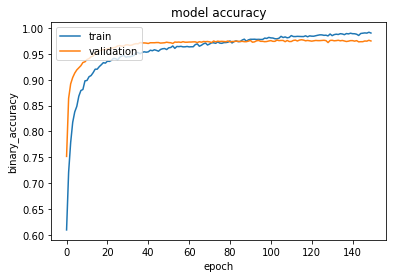

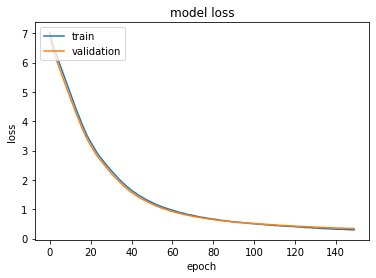

Best epoch: 116
Train Accuracy: 
458/458 [==============================] - 1s 3ms/step - loss: 0.2794 - binary_accuracy: 0.9946
Test Accuracy: 
7/7 [==============================] - 0s 3ms/step - loss: 1.3158 - binary_accuracy: 0.6547
Test loss: 1.3158245086669922
Test accuracy: 0.6547085046768188
[0.53787879 0.82417582]

0.681027306027306

Confusion matrix:
[[71 61]
 [16 75]]

Normalized confusion matrix:
[[0.53787879 0.46212121]
 [0.17582418 0.82417582]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.82      0.54      0.65       132
     label 1       0.55      0.82      0.66        91

    accuracy                           0.65       223
   macro avg       0.68      0.68      0.65       223
weighted avg       0.71      0.65      0.65       223

AUC-ROC: 0.681027306027306
MCC: 0.36479818207212805
precision: 0.6837812711291413
recall: 0.681027306027306
f1_score: 0.6545973890129342


In [55]:
epochs=150
for i in range(0, 1):
    # train - validation split:
    X_train, X_val, y_train,y_val  = train_test_split(X ,y , test_size=0.25, random_state=0)
    m = 'FFNN_laser'
    model1 = build_model(1024)
    model_fit(model1, X_train, y_train, X_val, y_val)
    results(model1, X_train, y_train, X_test, y_test)
    i += 1

In [56]:
# model_name = ['LR_laser', 'FFNN_laser']

# accuracy_list = [0.677130, 0.717489]
# loss_list = [11.151755,  1.182955]
# precision_list = [0.720717, 0.733391]
# recall_list = [0.710206, 0.737471]
# f1_score_list= [0.676343, 0.717284]
# auc_roc_list = [0.710206, 0.737471]
# mcc_list = [0.430795, 0.470844]
# training_time = [1.266331, 441.174413]

In [57]:
# accuracy_list

In [58]:
data = {
    "Model": model_name,
    "Accuracy": accuracy_list,
    "Loss": loss_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1 Score": f1_score_list,
    "AUC-ROC": auc_roc_list,
    "MCC": mcc_list,
    "training_time":training_time
}

data = pd.DataFrame(data)
# df.to_excel('models_results.xlsx', index=False, encoding='utf-8-sig')

In [59]:
data

,Model,Accuracy,Loss,Precision,Recall,F1 Score,AUC-ROC,MCC,training_time
0,LR_laser,0.686099,10.841984,0.726258,0.717782,0.685587,0.717782,0.443960,1.722005
1,FFNN_laser,0.654709,1.315825,0.683781,0.681027,0.654597,0.681027,0.364798,358.275412


In [60]:
data = pd.DataFrame(data)
data

,Model,Accuracy,Loss,Precision,Recall,F1 Score,AUC-ROC,MCC,training_time
0,LR_laser,0.686099,10.841984,0.726258,0.717782,0.685587,0.717782,0.443960,1.722005
1,FFNN_laser,0.654709,1.315825,0.683781,0.681027,0.654597,0.681027,0.364798,358.275412


In [61]:
data

,Model,Accuracy,Loss,Precision,Recall,F1 Score,AUC-ROC,MCC,training_time
0,LR_laser,0.686099,10.841984,0.726258,0.717782,0.685587,0.717782,0.443960,1.722005
1,FFNN_laser,0.654709,1.315825,0.683781,0.681027,0.654597,0.681027,0.364798,358.275412


In [62]:

grouped_results = data.reset_index().groupby('Model').mean().sort_values('index')
grouped_results = grouped_results.drop('index', axis=1)

grouped_results.reset_index(level=0, inplace=True)
# grouped_results.to_excel('grouped_results.xlsx', index=False, encoding='utf-8-sig')

In [63]:
grouped_results

,Model,Accuracy,Loss,Precision,Recall,F1 Score,AUC-ROC,MCC,training_time
0,LR_laser,0.686099,10.841984,0.726258,0.717782,0.685587,0.717782,0.443960,1.722005
1,FFNN_laser,0.654709,1.315825,0.683781,0.681027,0.654597,0.681027,0.364798,358.275412


In [64]:
grouped_results = grouped_results[grouped_results['Model'] != 'laser_em_batchnorm_l2']
grouped_results

,Model,Accuracy,Loss,Precision,Recall,F1 Score,AUC-ROC,MCC,training_time
0,LR_laser,0.686099,10.841984,0.726258,0.717782,0.685587,0.717782,0.443960,1.722005
1,FFNN_laser,0.654709,1.315825,0.683781,0.681027,0.654597,0.681027,0.364798,358.275412


In [65]:
# grouped_results = df.reset_index().groupby('Model').mean().sort_values('index')
# grouped_results = grouped_results.drop('index', axis=1)

# grouped_results.reset_index(level=0, inplace=True)
# grouped_results.to_excel('grouped_results.xlsx', index=False, encoding='utf-8-sig')

In [66]:
import plotly.graph_objs as go

# Count occurrences by model
counts = grouped_results['Accuracy']
model_names = grouped_results['Model']
# Create a bar chart using plotly
fig = go.Figure(data=[go.Bar(x=model_names, y=counts,
                             marker_color='#008B8B',  # set the color of the bars
                             text=[f'{model}: {accuracy:.0%}' for model, accuracy in zip(model_names, counts)],  # add model name and accuracy values as percentage to the bars
                             textposition='auto')])  # position the labels inside the bars

# Customize the layout
fig.update_layout(title='Accuracy by Model',
                  xaxis_title='Models',
                  yaxis_title='Accuracy',
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='#F8F8FF',
                  paper_bgcolor='#F8F8FF',
                  width=600,  # Update width
                  height=600)
# Adjust the width of the bars
fig.update_traces(marker=dict(line=dict(width=0.5)))  # decrease the width of the bars

# Show the plot
fig.show()


In [67]:
def plot_history(history):
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('binary_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [68]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report
# Compute confusion matrix
def confusion(predictions):
    cm = confusion_matrix(y_test1, predictions)
    accuracies = cm.diagonal()/cm.sum(axis=1)
    print(accuracies)
    print()

    # Calculate the average accuracy across all classes
    avg_accuracy = accuracies.mean()
    # Print the average accuracy
    print(avg_accuracy)
    print()
    
    # Print confusion matrix
    classes = np.unique(y_test1)
    print("Confusion matrix:")
    print(cm)
    print()

    # Print normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix:")
    print(cm_norm)
    print()

    print("Classification report:")
    print(classification_report(y_test1, predictions, target_names=[f"label {c}" for c in classes]))
    
    auc_roc = roc_auc_score(y_test1, predictions) # y_pred_prob is the predicted probability of class 1
    mcc = matthews_corrcoef(y_test1, predictions)
    print("AUC-ROC:", auc_roc)
    print("MCC:", mcc)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test1, predictions, average='macro')
    print("precision:", precision)
    print("recall:", recall)
    print("f1_score:", f1_score)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)
    auc_roc_list.append(auc_roc)
    mcc_list.append(mcc)
    model_name.append(m)

def results(model, x, y, x_t, y_t):    
    print('Train Accuracy: ')
    model.evaluate(x, y, verbose =1)

    print('Test Accuracy: ')
    loss, accuracy = model.evaluate(x_t , y_t , verbose =1)
    # Print the evaluation results
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    
    prediction = model.predict(x_t)
    for i in range(len(prediction)):
        if (prediction[i] < 0.5):
            prediction[i] = 0
        else: 
            prediction[i] = 1
    confusion(prediction)


In [69]:
def show_best_hps():
    print("Best Hyperparameters:")
    print(f" units_1 : {best_hps.get('units_1')}")
    print(f" act_1 : {best_hps.get('act_1')}")
    print(f" dropout_1 : {best_hps.get('dropout_1')}")
    print(f" units_2 : {best_hps.get('units_2')}")
    print(f" act_2 : {best_hps.get('act_2')}")
    print(f" dropout_2 : {best_hps.get('dropout_2')}")
    print(f" units_3 : {best_hps.get('units_3')}")
    print(f" act_3 : {best_hps.get('act_3')}")
    print(f" dropout_3 : {best_hps.get('dropout_3')}")
    print(f" units_4 : {best_hps.get('units_4')}")
    print(f" act_4 : {best_hps.get('act_4')}")
    print(f" dropout_4 : {best_hps.get('dropout_4')}")
    # print(f"Kernel size: {best_hps.get('kernel_size')}")
    print(f"Learning rate: {best_hps.get('learning_rate')}")
    
    
def build_model_tune(hp):
        
    #hyperparameters for layer 1 - 3
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=128)
    hp_act_1 = hp.Choice('act_1', ['relu', 'sigmoid'])
    hp_dropout_1 = hp.Float('dropout_1', 0, 0.5, step=0.1, default=0.25)
    #hyperparameters for layer 4 - 6
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=64)
    hp_act_2 = hp.Choice('act_2' , ['relu', 'sigmoid' ])
    hp_dropout_2 = hp.Float('dropout_2', 0, 0.5, step=0.1, default=0.25)
    #hyperparameters for layer 7 - 9 
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=128, step=32)
    hp_act_3 = hp.Choice('act_3' , ['relu', 'sigmoid' ])
    hp_dropout_3 = hp.Float('dropout_3', 0, 0.5, step=0.1, default=0.25)
    #hyperparameters for layer 10 - 12
    hp_units_4 = hp.Int('units_4', min_value=32, max_value=64, step=16)
    hp_act_4 = hp.Choice('act_4' , ['relu', 'sigmoid' ])
    hp_dropout_4 = hp.Float('dropout_4', 0, 0.5, step=0.1, default=0.25)
    #hyperparameters for compiling model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-4])
    
    #simple layers to train laser embedded sentences
    seq_input  = tfkl.Input(shape=(1024,),  name = "Sequential_Input")
    #input folowed by dense layer 1
    layer1 = Dense(units = hp_units_1, activation=hp_act_1, 
                   kernel_regularizer=tfk.regularizers.L2(0.001),  
                   name="layer1")(seq_input)
    layer2 = tfkl.BatchNormalization()(layer1)
    layer3 = tfkl.Dropout(hp_dropout_1)(layer2)   
    
    #Dense layer 2
    layer4 = Dense(units=hp_units_2, kernel_regularizer=tfk.regularizers.L2(0.001),  
                   activation=hp_act_2,name="layer4")(layer3)
    layer5 = tfkl.BatchNormalization()(layer4)
    layer6 = tfkl.Dropout(hp_dropout_2)(layer5)
        
    #Dense layer 3
    layer7 = Dense(units=hp_units_3, kernel_regularizer=tfk.regularizers.L2(0.001),  
                   activation=hp_act_3,name="layer7")(layer6)
    layer8 = tfkl.BatchNormalization()(layer7)
    layer9 = tfkl.Dropout(hp_dropout_3)(layer8)
    
    #Dense layer 4
    layer10 = Dense(units=hp_units_4, kernel_regularizer=tfk.regularizers.L2(0.001),  
                   activation=hp_act_4 ,name="layer10")(layer9)
    layer11 = tfkl.BatchNormalization()(layer10)
    layer12 = tfkl.Dropout(hp_dropout_4)(layer11)
    
    # the last layer of binary classification will have the activation function sigmoid
    output_layer  = tfkl.Dense(units=1, activation=tfk.activations.sigmoid, kernel_initializer=tfk.initializers.GlorotNormal(seed), name='Output')(layer12) 
        
    model = Model(inputs=seq_input,outputs=[output_layer], name = "CS_AWARE_Model")
    
    model.compile(loss = tfk.losses.BinaryCrossentropy(from_logits=True), 
                  optimizer=tfk.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics =  ['binary_accuracy'])
    return model


In [70]:
def model_fit(model,x, y, x_v, y_v):
    global num_saved_models, m, best_epoch
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
    history = model.fit(x, y, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.2, 
                        validation_data=([x_v,y_v]),
                        verbose=0,
                        callbacks=[callback,TrainingTimeCallback()])
    
    plot_history(history)
    model.save(f"model_{m}_{num_saved_models}.h5")
    val_acc_per_epoch = history.history['val_binary_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
    # Increment the counter for saved models
    num_saved_models += 1

In [71]:
X_train1, X_val1, y_train1, y_val1  = train_test_split(X, y , test_size=0.30, random_state=0)

In [72]:
X_test1 = X_test
y_test1 = y_test

In [73]:
X_val1.shape

(5858, 1024)

Search space summary
Default search space size: 13
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 128, 'sampling': None}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 64, 'sampling': None}
act_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
act_3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], '

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 416
act_1: sigmoid
dropout_1: 0.2
units_2: 224
act_2: relu
dropout_2: 0.4
units_3: 128
act_3: sigmoid
dropout_3: 0.2
units_4: 64
act_4: sigmoid
dropout_4: 0.2
learning_rate: 0.0001
Score: 0.976408189535141
Trial summary
Hyperparameters:
units_1: 416
act_1: sigmoid
dropout_1: 0.0
units_2: 224
act_2: relu
dropout_2: 0.2
units_3: 96
act_3: relu
dropout_3: 0.2
units_4: 48
act_4: sigmoid
dropout_4: 0.30000000000000004
learning_rate: 0.0001
Score: 0.9757132291793823
Trial summary
Hyperparameters:
units_1: 288
act_1: relu
dropout_1: 0.4
units_2: 160
act_2: sigmoid
dropout_2: 0.4
units_3: 32
act_3: relu
dropout_3: 0.1
units_4: 48
act_4: sigmoid
dropout_4: 0.1
learning_rate: 0.0001
Score: 0.9752377331256866
Trial summary
Hyperparameters:
units_1: 160
act_1: sigmoid
dropout_1: 0.5
units_2: 96
act_2: sigmoid
dropout_2: 0.30000000000000004
units_3: 64
act_3: relu
dropout_3: 0.0
units_4: 48


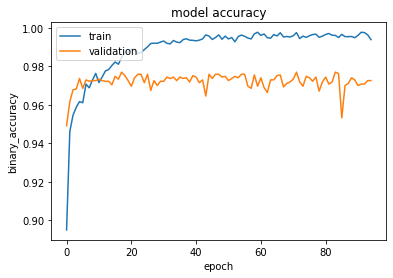

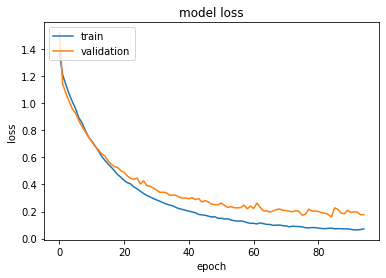

Best epoch: 18
Train Accuracy: 
428/428 [==============================] - 1s 3ms/step - loss: 0.0831 - binary_accuracy: 0.9947
Test Accuracy: 
7/7 [==============================] - 0s 3ms/step - loss: 1.0301 - binary_accuracy: 0.7578
Test loss: 1.0300674438476562
Test accuracy: 0.7578475475311279
[0.71969697 0.81318681]

0.7664418914418915

Confusion matrix:
[[95 37]
 [17 74]]

Normalized confusion matrix:
[[0.71969697 0.28030303]
 [0.18681319 0.81318681]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.85      0.72      0.78       132
     label 1       0.67      0.81      0.73        91

    accuracy                           0.76       223
   macro avg       0.76      0.77      0.76       223
weighted avg       0.77      0.76      0.76       223

AUC-ROC: 0.7664418914418915
MCC: 0.5238050301778008
precision: 0.7574404761904762
recall: 0.7664418914418915
f1_score: 0.7556808959584482
Best epoch: 18

Retrain the model with best hps 

/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



Training time: 153.05726647377014 seconds


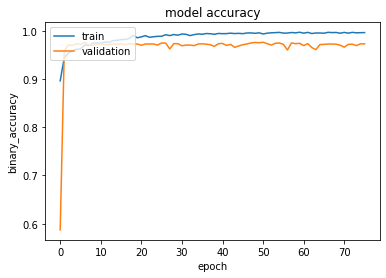

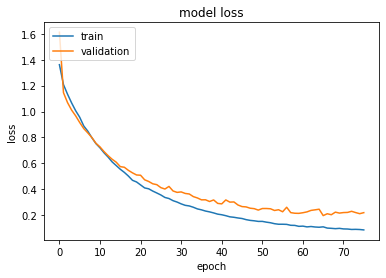

Best epoch: 51
Train Accuracy: 
428/428 [==============================] - 1s 3ms/step - loss: 0.1128 - binary_accuracy: 0.9941
Test Accuracy: 
7/7 [==============================] - 0s 3ms/step - loss: 0.9655 - binary_accuracy: 0.7220
Test loss: 0.9655418395996094
Test accuracy: 0.7219731211662292
[0.65909091 0.81318681]

0.7361388611388611

Confusion matrix:
[[87 45]
 [17 74]]

Normalized confusion matrix:
[[0.65909091 0.34090909]
 [0.18681319 0.81318681]]

Classification report:
              precision    recall  f1-score   support

     label 0       0.84      0.66      0.74       132
     label 1       0.62      0.81      0.70        91

    accuracy                           0.72       223
   macro avg       0.73      0.74      0.72       223
weighted avg       0.75      0.72      0.72       223

AUC-ROC: 0.7361388611388613
MCC: 0.46528062846600504
precision: 0.72919360051713
recall: 0.7361388611388611
f1_score: 0.7210250201775625


In [74]:
    epochs = 150
    #Tuner
    tuner = RandomSearch(
        build_model_tune,
        objective = 'val_binary_accuracy',
        max_trials = 10,
        executions_per_trial = 10,
        #overwrite=True,
    )
    # not necessary to see it every time
    tuner.search_space_summary()
    
    tuner.search(X_train1, y_train1, 
                    epochs=50, 
                    batch_size=batch_size, 
                    validation_split=0.2, 
                    verbose=0,#not necessary to see all trainings
                    validation_data=([X_val1, y_val1])
                )
    tuner.results_summary()
    
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    print()
    print('best parameters that have been found: ')
    show_best_hps()
    print()

    print()
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    tuned_model = tuner.hypermodel.build(best_hps)
    #sow only the model with best params
    print(tuned_model.summary())
    global history

    m = 'tunned_model_laser'        
    history = model_fit(tuned_model, X_train1, y_train1, X_val1, y_val1)
    results(tuned_model, X_train1, y_train1, X_test, y_test)

    print('Best epoch: %d' % (best_epoch,))
    hypermodel = tuner.hypermodel.build(best_hps)
    
    # Retrain the model with best epoch
    print()
    print("Retrain the model with best hps and epoch: ")
    print('Hypermodel: ')
    m = 'hypermodel_laser'        
    model_fit(hypermodel, X_train1, y_train1, X_val1, y_val1)
    results(hypermodel, X_train1, y_train1, X_test, y_test)
    

In [75]:
# results(tuned_model, X_train1, y_train1, X_test, y_test)

    

In [76]:

#     print('Best epoch: %d' % (best_epoch,))
    

#     hypermodel = tuner.hypermodel.build(best_hps)
    
#     # Retrain the model with best epoch
#     print()
#     print("Retrain the model with best hps and epoch: ")
#     print('Hypermodel: ')
#     m = 'hypermodel_laser'        
#     model_fit(hypermodel, X_train1, y_train1, X_val1, y_val1)
#     results(hypermodel, X_train1, y_train1, X_test, y_test)

In [77]:
# loss, accuracy = tuned_model.evaluate(scaled_vectors_test, y_test1, verbose =1)
# # Print the evaluation results
# print('Test loss:', loss)
# print('Test accuracy:', accuracy)

In [78]:
model_name

['LR_laser', 'FFNN_laser', 'tunned_model_laser', 'hypermodel_laser']

In [79]:
data3 = {
    "Model": model_name,
    "Accuracy": accuracy_list,
    "Loss": loss_list,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1 Score": f1_score_list,
    "AUC-ROC": auc_roc_list,
    "MCC": mcc_list,
    "training_time":training_time
}

# df.to_excel('models_results.xlsx', index=False, encoding='utf-8-sig')
data3 = pd.DataFrame(data3)
# grouped_results = data2.reset_index().groupby('Model').mean().sort_values('index')
# grouped_results = grouped_results.drop('index', axis=1)

# grouped_results.reset_index(level=0, inplace=True)
data3.to_excel('results_model_1.xlsx', index=False, encoding='utf-8-sig')
data3

,Model,Accuracy,Loss,Precision,Recall,F1 Score,AUC-ROC,MCC,training_time
0,LR_laser,0.686099,10.841984,0.726258,0.717782,0.685587,0.717782,0.443960,1.722005
1,FFNN_laser,0.654709,1.315825,0.683781,0.681027,0.654597,0.681027,0.364798,358.275412
2,tunned_model_laser,0.757848,1.030067,0.757440,0.766442,0.755681,0.766442,0.523805,190.658727
3,hypermodel_laser,0.721973,0.965542,0.729194,0.736139,0.721025,0.736139,0.465281,153.057266


In [80]:
import plotly.graph_objs as go

# Count occurrences by model
counts = data3['Accuracy']
model_names = data3['Model']
# Create a bar chart using plotly
fig = go.Figure(data=[go.Bar(x=model_names, y=counts,
                             marker_color='#008B8B',  # set the color of the bars
                             text=[f'{model}: {accuracy:.0%}' for model, accuracy in zip(model_names, counts)],  # add model name and accuracy values as percentage to the bars
                             textposition='auto')])  # position the labels inside the bars

# Customize the layout
fig.update_layout(title='Accuracy by Model',
                  xaxis_title='Models',
                  yaxis_title='Accuracy',
                  font=dict(size=16),
                  margin=dict(l=50, r=50, t=50, b=50),
                  plot_bgcolor='#F8F8FF',
                  paper_bgcolor='#F8F8FF',
                  width=600,  # Update width
                  height=600)
# Adjust the width of the bars
fig.update_traces(marker=dict(line=dict(width=0.5)))  # decrease the width of the bars

# Show the plot
fig.show()
